In [3]:
!pip install --upgrade yfinance==0.2.54
!pip install arch
!pip install scikit-learn
!pip install --upgrade yfinance==0.2.54
!pip install arch
!pip install scikit-learn
!pip install pandas_datareader
!pip install PyPortfolioOpt
!pip install pandas_datareader
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.9 MB/s eta 0:00:00


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


Forecast for Mkt-RF: Mean = 0.014492405016549137, Variance = 0.002810010344734319


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Forecast for SMB: Mean = 0.0009007663382154529, Variance = 0.0


[*********************100%***********************]  1 of 1 completed

Forecast for HML: Mean = -0.0010680648657988012, Variance = 0.0019849601833990048
Forecast-based Portfolio Performance: (0.2710673841192437, 0.18694899465413295, 1.4499536872115033)


Market-implied prior returns:
 Ticker
AAPL     0.446606
BRK-B    0.136649
GOOG     0.314747
JNJ      0.097532
JPM      0.241886
MSFT     0.307347
PG       0.080759
V        0.219152
dtype: float64
Black–Litterman Portfolio Performance: (0.3083358500151362, 0.23291712653811103, 1.3238006779406357)
Market Prior Portfolio Performance: (0.31178098905951135, 0.2337650197424907, 1.3337367130589552)
Out-of-sample return for forecast-based portfolio: 35.0095369579354
Out-of-sample return for Black–Litterman portfolio: 144.53385596960413
Out-of-sample return for Market Prior portfolio: 147.96501928448916


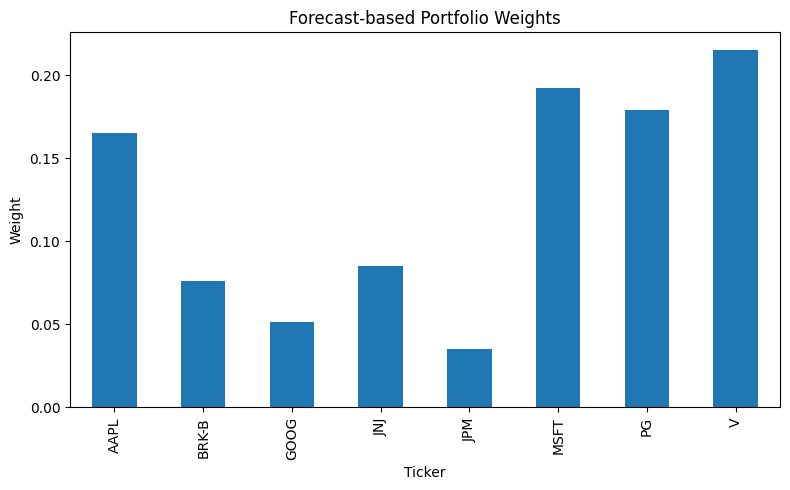

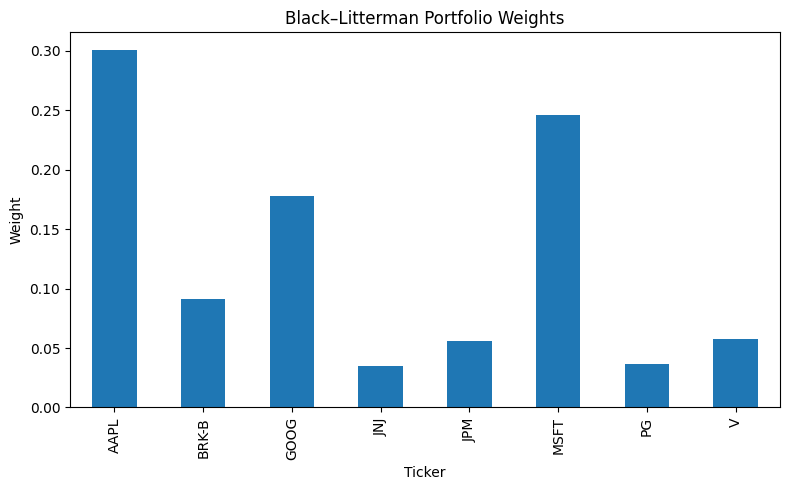

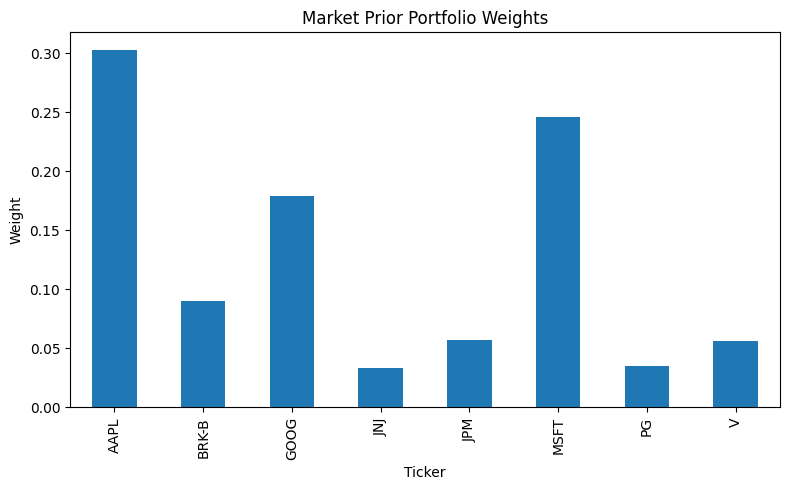


Final Results:
weights_forecast: OrderedDict([('AAPL', 0.1653629589596855), ('BRK-B', 0.0761618066316883), ('GOOG', 0.0513921908644726), ('JNJ', 0.0854702944016341), ('JPM', 0.0352722864355562), ('MSFT', 0.1921798422862661), ('PG', 0.1789824828676332), ('V', 0.2151781375530639)])
perf_forecast: (0.2710673841192437, 0.18694899465413295, 1.4499536872115033)
weights_bl: OrderedDict([('AAPL', 0.3005409045478458), ('BRK-B', 0.0908299938731844), ('GOOG', 0.1777793537149347), ('JNJ', 0.0351198906022146), ('JPM', 0.056335232668062), ('MSFT', 0.2457400653514522), ('PG', 0.0364620791113488), ('V', 0.0571924801309576)])
perf_bl: (0.3083358500151362, 0.23291712653811103, 1.3238006779406357)
weights_market: OrderedDict([('AAPL', 0.3025216227128285), ('BRK-B', 0.0900428636673715), ('GOOG', 0.1794018554156542), ('JNJ', 0.0338063419837726), ('JPM', 0.0570653516166326), ('MSFT', 0.246295799811735), ('PG', 0.0347540150748994), ('V', 0.0561121497171063)])
perf_market: (0.31178098905951135, 0.23376501974

In [6]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from pypfopt import EfficientFrontier, risk_models, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import cvxpy as cp

# --- Helper functions --- #

def load_fama_french_data(filepath: str) -> pd.DataFrame:
    ff = pd.read_csv(filepath, skiprows=4, header=0,
                     names=['Date', 'Mkt-RF', 'SMB', 'HML', 'RF'])
    ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m')
    ff.set_index('Date', inplace=True)
    ff = ff.astype(float) / 100  # convert percentages to decimals
    return ff

def download_stock_prices(tickers: list, start_date: str, end_date: str, interval: str = '1mo') -> pd.DataFrame:
    prices = yf.download(tickers, start=start_date, end=end_date,
                          interval=interval, auto_adjust=True)['Close']
    return prices

def download_index_data(index_symbol: str, start_date: str, end_date: str, interval: str = '1mo') -> pd.Series:
    index_data = yf.download(index_symbol, start=start_date, end=end_date,
                             interval=interval, auto_adjust=True)['Close']
    return index_data

def garch_aic_sel(returns: pd.Series):
    mean_models = ['Constant', 'AR']
    vol_models = ['GARCH', 'EGARCH']
    dists = ['normal', 't']
    results = []
    for mean in mean_models:
        for vol in vol_models:
            for dist in dists:
                lags = 1 if mean == 'AR' else 0
                model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')
                results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': res.aic})
    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['aic'].idxmin()]
    return best_model['mean'], best_model['vol'], best_model['dist']

def forecast_factor(series: pd.Series, scale: float = 100) -> dict:
    # Convert to log-returns and scale the series for stability
    series = np.log(1 + series.dropna())
    scaled_series = scale * series
    mean, vol, dist = garch_aic_sel(scaled_series)
    am = arch_model(scaled_series, mean=mean, vol=vol, p=1, q=1, dist=dist)
    res = am.fit(disp='off')
    forecast = res.forecast(horizon=1, reindex=False)
    next_mean_scaled = forecast.mean.iloc[-1, 0] / scale
    next_variance_scaled = forecast.variance.iloc[-1, 0] / (scale ** 2)
    next_step_mean = np.exp(next_mean_scaled + next_variance_scaled / 2) - 1
    next_step_variance = (np.exp(next_variance_scaled) - 1) * np.exp(2 * next_mean_scaled + next_variance_scaled)
    return {'next_step_mean': next_step_mean, 'next_step_variance': next_step_variance}

def run_factor_regressions(returns: pd.DataFrame, ff: pd.DataFrame) -> tuple:
    tickers = returns.columns.tolist()
    regression_results = {}
    coefficients = {}
    for ticker in tickers:
        df = pd.DataFrame({'r': returns[ticker]})
        df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])
        df['excess'] = df['r'] - df['RF']
        X = sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])
        y = df['excess']
        model = sm.OLS(y, X).fit()
        regression_results[ticker] = model
        coefficients[ticker] = {
            'alpha': model.params['const'],
            'Mkt-RF': model.params['Mkt-RF'],
            'SMB': model.params['SMB'],
            'HML': model.params['HML']
        }
    return regression_results, coefficients

def forecast_expected_returns(coefficients: dict, factor_forecasts: dict,
                              factors: list = ['Mkt-RF', 'SMB', 'HML']) -> dict:
    forecast_r = {}
    for ticker, coeff in coefficients.items():
        r_forecast = coeff['alpha']
        for factor in factors:
            r_forecast += coeff[factor] * factor_forecasts[factor]['next_step_mean']
        forecast_r[ticker] = r_forecast
    return forecast_r

def forecast_error_variance(regression_results: dict, coefficients: dict, factor_forecasts: dict,
                            factors: list = ['Mkt-RF', 'SMB', 'HML']) -> dict:
    forecast_errors = {}
    for ticker, model in regression_results.items():
        beta_squared_sum = sum(coefficients[ticker][factor]**2 * factor_forecasts[factor]['next_step_variance']
                               for factor in factors)
        sigma2_reg = model.mse_resid
        forecast_errors[ticker] = beta_squared_sum + sigma2_reg
    return forecast_errors

def mvar_lognormal_transform(mu: pd.Series, sigma: pd.DataFrame, horizon: int = 1) -> tuple:
    mu = mu * horizon
    sigma = sigma * horizon
    mu_ln = np.exp(mu + np.diag(sigma) / 2)
    outerprod = np.outer(mu_ln, mu_ln)
    sigma_ln = outerprod * (np.exp(sigma) - 1)
    return mu_ln - 1, sigma_ln

def optimize_portfolio(mu: np.ndarray, S: np.ndarray, method: str = 'max_sharpe'):
    ef = EfficientFrontier(mu, S)
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    else:
        raise ValueError("Unsupported optimization method.")
    performance = ef.portfolio_performance(verbose=False)
    return weights, performance, ef

def optimize_black_litterman(S: np.ndarray, prior: np.ndarray, views: dict, omega: np.ndarray,
                             method: str = 'max_sharpe'):
    bl = BlackLittermanModel(S, pi=prior, absolute_views=views, omega=omega)
    mu_bl = bl.bl_returns()
    ef = EfficientFrontier(mu_bl, S)
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    else:
        raise ValueError("Unsupported optimization method.")
    performance = ef.portfolio_performance(verbose=False)
    return weights, performance, mu_bl, ef

def optimize_market_portfolio(prior: np.ndarray, S: np.ndarray, method: str = 'max_sharpe'):
    ef = EfficientFrontier(prior, S)
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    else:
        raise ValueError("Unsupported optimization method.")
    performance = ef.portfolio_performance(verbose=False)
    return weights, performance, ef

def compute_out_of_sample_return(weights: dict, test_data: pd.DataFrame, annualizer: int = 252) -> float:
    weights_series = pd.Series(weights)
    test_returns = test_data.pct_change().dropna()
    portfolio_daily_returns = (test_returns * weights_series).sum(axis=1)
    realized_return = (1 + portfolio_daily_returns).prod() ** (annualizer / len(portfolio_daily_returns)) - 1
    return realized_return

# --- Class that encapsulates the analysis --- #

class PortfolioAnalysis:
    def __init__(self, ff_filepath: str, tickers: list, start_date: str,
                 end_date: str, index_symbol: str):
        self.ff_filepath = ff_filepath
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.index_symbol = index_symbol

        # Placeholders for intermediate results
        self.ff = None
        self.prices = None
        self.returns = None
        self.factor_forecasts = {}
        self.regression_results = {}
        self.coefficients = {}
        self.forecast_r = {}
        self.forecast_errors = {}
        self.mu = None
        self.S_train = None
        self.weights_forecast = None
        self.perf_forecast = None
        self.weights_bl = None
        self.perf_bl = None
        self.mu_bl = None
        self.weights_market = None
        self.perf_market = None
        self.oos_return_forecast = None
        self.oos_return_bl = None
        self.oos_return_market = None

    def load_data(self):
        """Loads Fama–French factor data and stock prices, aligning the dates."""
        self.ff = load_fama_french_data(self.ff_filepath)
        self.prices = download_stock_prices(self.tickers, self.start_date, self.end_date, interval='1mo')
        self.returns = self.prices.pct_change().dropna()
        common_dates = self.returns.index.intersection(self.ff.index)
        if common_dates.empty:
            raise ValueError("No common dates found between stock returns and Fama–French data.")
        self.returns = self.returns.loc[common_dates]
        self.ff = self.ff.loc[common_dates]

    def forecast_factors(self):
        """Forecasts each factor’s next period mean and variance using a GARCH model."""
        factors = ['Mkt-RF', 'SMB', 'HML']
        for factor in factors:
            series = self.ff[factor].dropna()
            self.factor_forecasts[factor] = forecast_factor(series, scale=100)
            print(f"Forecast for {factor}: Mean = {self.factor_forecasts[factor]['next_step_mean']}, "
                  f"Variance = {self.factor_forecasts[factor]['next_step_variance']}")

    def run_regressions(self):
        """Runs OLS regressions to obtain factor loadings and residual variances."""
        self.regression_results, self.coefficients = run_factor_regressions(self.returns, self.ff)

    def compute_forecasts(self):
        """Computes expected returns and forecast error variances for each asset."""
        self.forecast_r = forecast_expected_returns(self.coefficients, self.factor_forecasts)
        self.forecast_errors = forecast_error_variance(self.regression_results, self.coefficients, self.factor_forecasts)

    def optimize_portfolios(self):
        """Optimizes portfolios based on forecasted returns and using Black–Litterman views."""
        annualizer_monthly = 12
        annualized_return = {ticker: self.forecast_r[ticker] * annualizer_monthly for ticker in self.tickers}
        annualized_error = {ticker: np.sqrt(self.forecast_errors[ticker]) * np.sqrt(annualizer_monthly)
                            for ticker in self.tickers}
        # Compute sample covariance using log returns
        S_sample = risk_models.sample_cov(self.prices, frequency=1, log_returns=True)
        mu_log = np.log(1 + pd.Series(self.forecast_r))
        self.mu, self.S_train = mvar_lognormal_transform(mu_log, S_sample, horizon=12)

        # Forecast-based portfolio optimization
        self.weights_forecast, self.perf_forecast, _ = optimize_portfolio(self.mu, self.S_train, method='max_sharpe')
        print("Forecast-based Portfolio Performance:", self.perf_forecast)

        # Black–Litterman optimization
        viewdict = {ticker: annualized_return[ticker] for ticker in self.tickers}
        view_omega = np.diag([annualized_error[ticker] for ticker in self.tickers])
        sp500 = download_index_data(self.index_symbol, self.start_date, '2024-12-31', interval='1mo')
        delta = black_litterman.market_implied_risk_aversion(sp500, frequency=annualizer_monthly,
                                                             risk_free_rate=0.05/annualizer_monthly)
        mcaps = {ticker: yf.Ticker(ticker).info['marketCap'] for ticker in self.tickers}
        prior = black_litterman.market_implied_prior_returns(mcaps, delta, self.S_train)
        print("Market-implied prior returns:\n", prior)
        self.weights_bl, self.perf_bl, self.mu_bl, _ = optimize_black_litterman(self.S_train, prior,
                                                                               viewdict, view_omega,
                                                                               method='max_sharpe')
        print("Black–Litterman Portfolio Performance:", self.perf_bl)

        # Market-implied (prior) portfolio optimization
        self.weights_market, self.perf_market, _ = optimize_market_portfolio(prior, self.S_train, method='max_sharpe')
        print("Market Prior Portfolio Performance:", self.perf_market)

    def evaluate_out_of_sample(self, prices_test: pd.DataFrame):
        """Evaluates the optimized portfolios on out-of-sample test data."""
        annualizer = 252
        self.oos_return_forecast = compute_out_of_sample_return(self.weights_forecast, prices_test, annualizer)
        self.oos_return_bl = compute_out_of_sample_return(self.weights_bl, prices_test, annualizer)
        self.oos_return_market = compute_out_of_sample_return(self.weights_market, prices_test, annualizer)
        print(f"Out-of-sample return for forecast-based portfolio: {self.oos_return_forecast}")
        print(f"Out-of-sample return for Black–Litterman portfolio: {self.oos_return_bl}")
        print(f"Out-of-sample return for Market Prior portfolio: {self.oos_return_market}")

    def plot_figures(self):
        """Plots portfolio weights for each optimization method."""
        # Plot forecast-based portfolio weights
        plt.figure(figsize=(8, 5))
        pd.Series(self.weights_forecast).plot(kind="bar", title="Forecast-based Portfolio Weights")
        plt.xlabel("Ticker")
        plt.ylabel("Weight")
        plt.tight_layout()
        plt.show()

        # Plot Black–Litterman portfolio weights
        plt.figure(figsize=(8, 5))
        pd.Series(self.weights_bl).plot(kind="bar", title="Black–Litterman Portfolio Weights")
        plt.xlabel("Ticker")
        plt.ylabel("Weight")
        plt.tight_layout()
        plt.show()

        # Plot Market Prior portfolio weights
        plt.figure(figsize=(8, 5))
        pd.Series(self.weights_market).plot(kind="bar", title="Market Prior Portfolio Weights")
        plt.xlabel("Ticker")
        plt.ylabel("Weight")
        plt.tight_layout()
        plt.show()

    def run_analysis(self, prices_test: pd.DataFrame) -> dict:
        """Executes the entire workflow and returns key results."""
        self.load_data()
        self.forecast_factors()
        self.run_regressions()
        self.compute_forecasts()
        self.optimize_portfolios()
        self.evaluate_out_of_sample(prices_test)
        # Optionally, plot the portfolio weight figures:
        self.plot_figures()
        return {
            'weights_forecast': self.weights_forecast,
            'perf_forecast': self.perf_forecast,
            'weights_bl': self.weights_bl,
            'perf_bl': self.perf_bl,
            'weights_market': self.weights_market,
            'perf_market': self.perf_market,
            'oos_return_forecast': self.oos_return_forecast,
            'oos_return_bl': self.oos_return_bl,
            'oos_return_market': self.oos_return_market
        }

# --- Example of running the analysis --- #

if __name__ == '__main__':
    # Define parameters for the analysis
    ff_filepath = 'F-F_Research_Data_Factors.CSV'
    tickers = ["AAPL", "MSFT", "GOOG", "BRK-B", "JPM", "JNJ", "V", "PG"]
    start_date = '2009-12-31'
    end_date = '2023-12-31'
    index_symbol = "^GSPC"

    # Download out-of-sample price data for evaluation
    prices_test = download_stock_prices(tickers, end_date, '2024-12-31', interval='1mo')

    # Create an instance of the analysis class and run the analysis
    analysis = PortfolioAnalysis(ff_filepath, tickers, start_date, end_date, index_symbol)
    results = analysis.run_analysis(prices_test)

    # The results dictionary contains weights, performance metrics, and out-of-sample returns.
    print("\nFinal Results:")
    for key, value in results.items():
        print(f"{key}: {value}")